## Goal of Analysis:

### 1. Evaluate the impact of the referral program

### 2. What will be the next step based on the data

### 3. Design a method to measure the result before and after the referral program

### Part 1: Laod Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
referral = pd.read_csv('referral.csv', parse_dates = ['date'])

# I will eliminate the device id for easier manipulation
referral = referral[['user_id', 'date', 'country', 'money_spent', 'is_referral']]

referral.head()

,user_id,date,country,money_spent,is_referral
0,2,2015-10-03,FR,65,0
1,3,2015-10-03,CA,54,0
2,6,2015-10-03,FR,35,0
3,7,2015-10-03,UK,73,0
4,7,2015-10-03,MX,35,0


In [3]:
referral.dtypes

user_id                 int64
date           datetime64[ns]
country                object
money_spent             int64
is_referral             int64
dtype: object

In [4]:
referral.isnull().sum()

user_id        0
date           0
country        0
money_spent    0
is_referral    0
dtype: int64

In [5]:
set(referral['country'])

{'CA', 'CH', 'DE', 'ES', 'FR', 'IT', 'MX', 'UK', 'US'}

I have converted the date to datetime and checked that the dataframe does not have null value

The program starts on Oct 31, 2015, so I need to check how many days before and after the program start date

In [6]:
import datetime

referral_start_date = datetime.datetime(2015,10,31)

In [7]:
(pd.Series(referral.date.unique()) >= referral_start_date).value_counts()

False    28
True     28
dtype: int64

There are 28 days before and 28 days after the program start date, equally distributed

### Part 2: Data Preprocess and EDA

In [8]:
# extract date information
referral['dayofweek'] = referral['date'].apply(lambda x: x.dayofweek)
referral.head()

,user_id,date,country,money_spent,is_referral,dayofweek
0,2,2015-10-03,FR,65,0,5
1,3,2015-10-03,CA,54,0,5
2,6,2015-10-03,FR,35,0,5
3,7,2015-10-03,UK,73,0,5
4,7,2015-10-03,MX,35,0,5


We first take a look at the each country's referral and money spent information

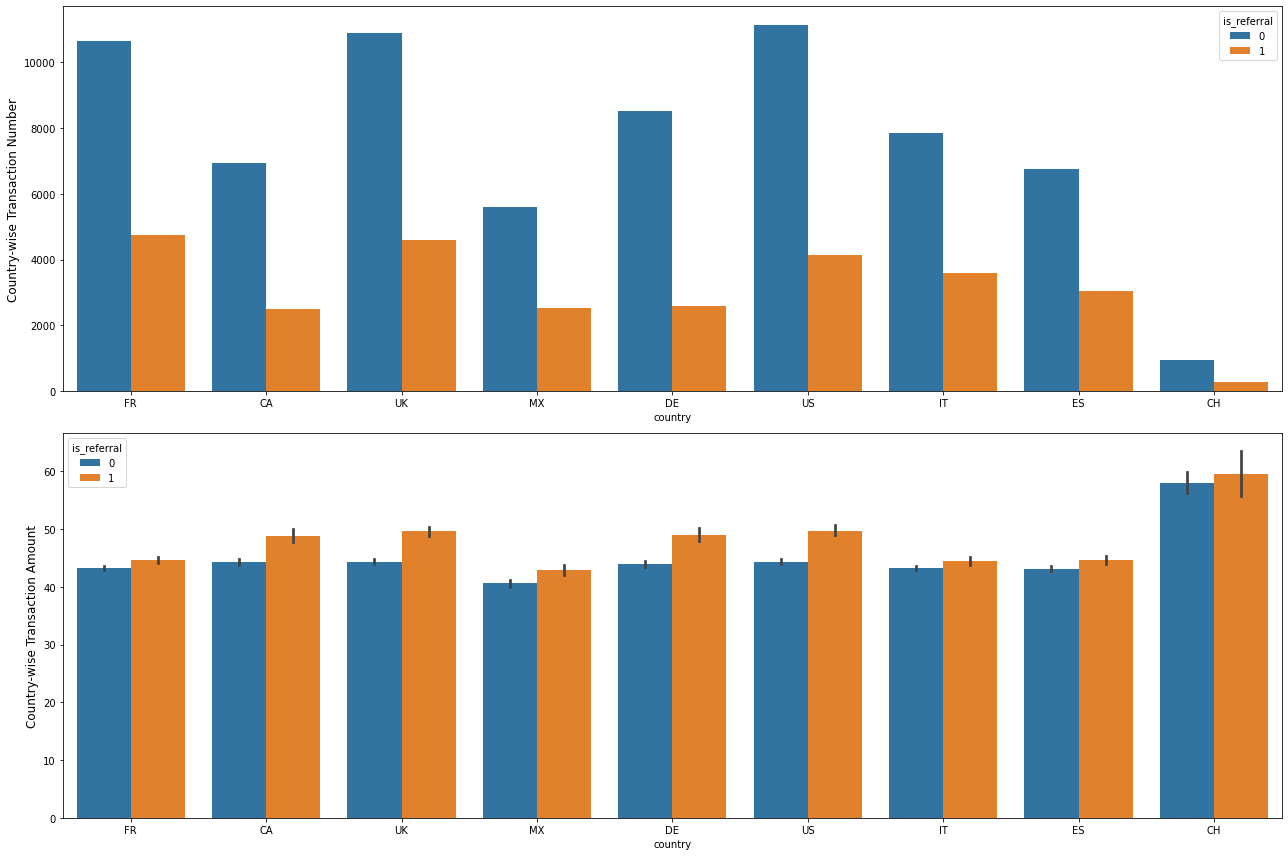

In [9]:
# daily money spent visualization
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='country', hue='is_referral', data=referral, ax=ax[0])
ax[0].set_ylabel('Country-wise Transaction Number', fontsize=12)

sns.barplot(x='country', y='money_spent', hue='is_referral', data=referral, ax=ax[1])
ax[1].set_ylabel('Country-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

Also take a look at whether dayofweek has impact on the money spent on each country

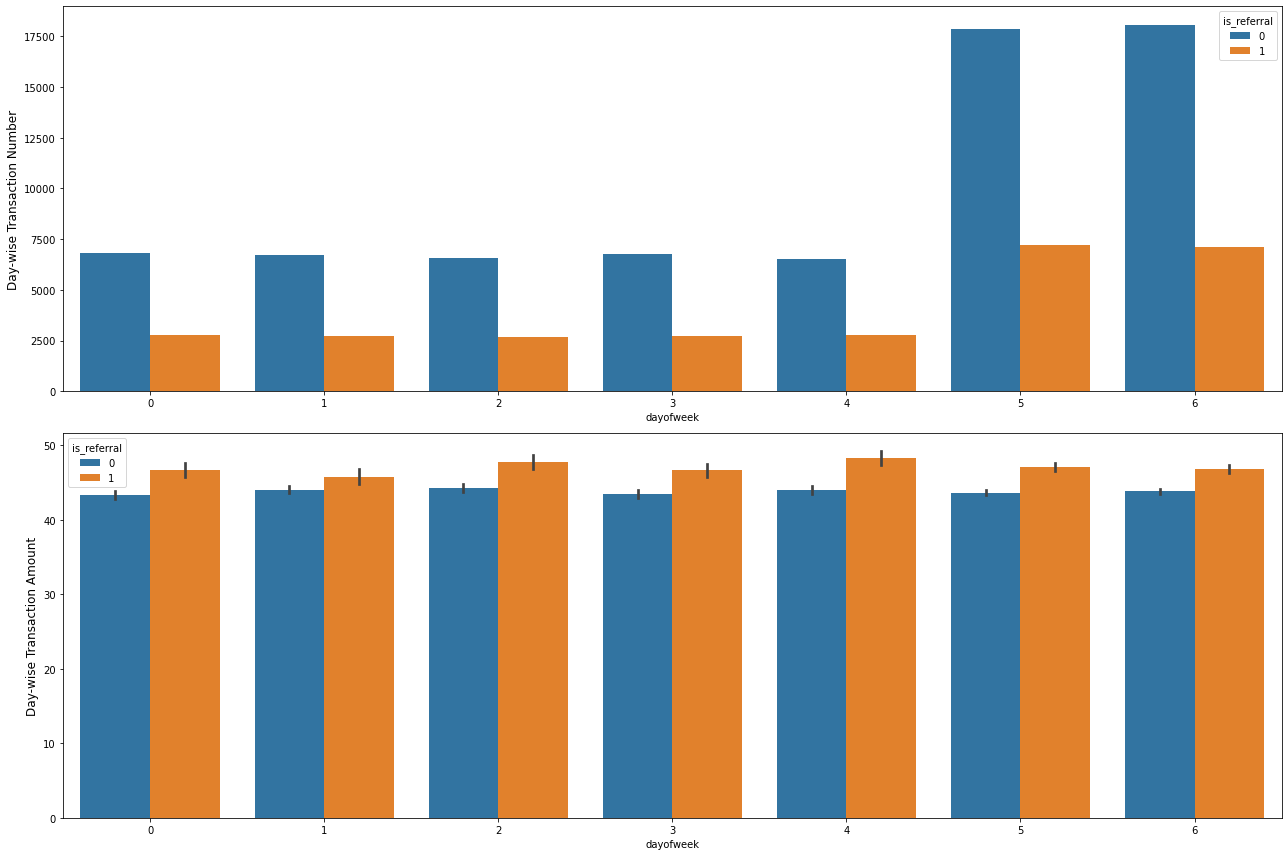

In [10]:
# daily money spent visualization (Monday is 0 and Sunday is 6)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='dayofweek', hue='is_referral', data=referral, ax=ax[0])
ax[0].set_ylabel('Day-wise Transaction Number', fontsize=12)

sns.barplot(x='dayofweek', y='money_spent', hue='is_referral', data=referral, ax=ax[1])
ax[1].set_ylabel('Day-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

We can see that when there are referrals, people tend to spend more money. Also, people tend to spend more during weekends (day 5-6)

### Part 3: Case Analysis

In [11]:
def basic_stat(df):
    """ function to calculate statistics """
    no_purchase = len(df)
    money_spent = df['money_spent'].sum()
    unique_user = len(df['user_id'].unique())
    
    return pd.Series([no_purchase, money_spent, unique_user], 
                     index=['no_purchase', 'money_spent', 'unique_user'])

In [16]:
from scipy.stats import ttest_ind

def daily_stat(data):
    grouped = data.groupby('date').apply(basic_stat).reset_index()
    ref = grouped[grouped['date'] < referral_start_date]
    new = grouped[grouped['date'] >= referral_start_date]
    
    names = ['no_purchase', 'money_spent', 'unique_user']
    vals = []
    for name in names:
        a = ref[name].values
        b = new[name].values
        # p-value should be one-side test
        p_val = ttest_ind(a, b, equal_var=False)[1] / 2
        vals.append(p_val)
        
    return pd.Series(vals, index=names)

In [17]:
# analysis of user's daily information

daily_stat(referral)

no_purchase    0.348257
money_spent    0.135194
unique_user    0.059545
dtype: float64

In [18]:
# analysis of country information

referral.groupby('country').apply(daily_stat).reset_index()

,country,no_purchase,money_spent,unique_user
0,CA,0.233985,0.351704,0.268256
1,CH,0.003072,0.006941,0.003142
2,DE,0.011798,0.081459,0.015665
3,ES,0.072638,0.037522,0.057954
4,FR,0.058996,0.031843,0.041124
5,IT,0.057454,0.025730,0.043911
6,MX,0.032430,0.009670,0.026203
7,UK,0.261183,0.048490,0.204398
8,US,0.307801,0.248874,0.368860


In [19]:
# analysis of dayofweek

referral.groupby('dayofweek').apply(daily_stat).reset_index()

,dayofweek,no_purchase,money_spent,unique_user
0,0,0.012484,0.000368,0.000665
1,1,0.156965,0.007701,0.008802
2,2,0.009713,0.000301,0.001270
3,3,0.016584,0.000675,0.002578
4,4,0.016875,0.000595,0.000683
5,5,0.006828,0.000107,0.000125
6,6,0.011717,0.000133,0.000012


### Fianl Answer to the questions:

#### 1. 

According to the analysis above, the program doesn't seem have significant impacts to the whole company as a whole.

However, situations are different on each country:

 - the program fails in CH and DE, it significantly decrease the sales in these two countries.
 - the program succeeds in 'MX','IT','FR','ES', it significantly increase the sales.
 - the program doesn't seem have any significant effect on UK,CA,US, especially on CA and US.


#### 2.

I suggest to perform more accurate A/B test and collect more data, to study the impact of the program.

since the program has different impact in different country, I suggest studying the reason of such difference. for example, does the program has any cultural conflicts in CH and DE?


#### 3. 

This approach isn't an accurate A/B test. "User Referral" program isn't the only difference between control group and test group. For example, there may be some special holidays after Oct 31 in some countries that will influence the results.

To get more accurate impact of the program, we need to perform a more careful A/B test. 

For example: during the same peroid of time, randomly split the customers into two groups, and let only one group know the User Referral program. Then run the experiment for a while and perform the t-test to see whether some 'sale performance index' (e.g., daily spent, daily customers, daily transactions) have significant changes.